# Scatter plot

In [3]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [75]:
import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar

from src.constants import *
from src.datasources import codab, imerg

## Load data

### CODAB

In [5]:
adm0 = codab.load_codab_from_blob()

## Historical stats

Calculated in `ibtracs_imerg_agg.ipynb` then merged with EM-DAT in `emdat.ipynb`

In [45]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/ibtracs_imerg_emdat_stats_50km.parquet"
)
df_stats = stratus.load_parquet_from_blob(blob_name)

In [46]:
df_stats["Total Affected"] = df_stats["Total Affected"].fillna(0)
df_stats = df_stats[df_stats["season"] < 2025]

## Check correlations

<Axes: >

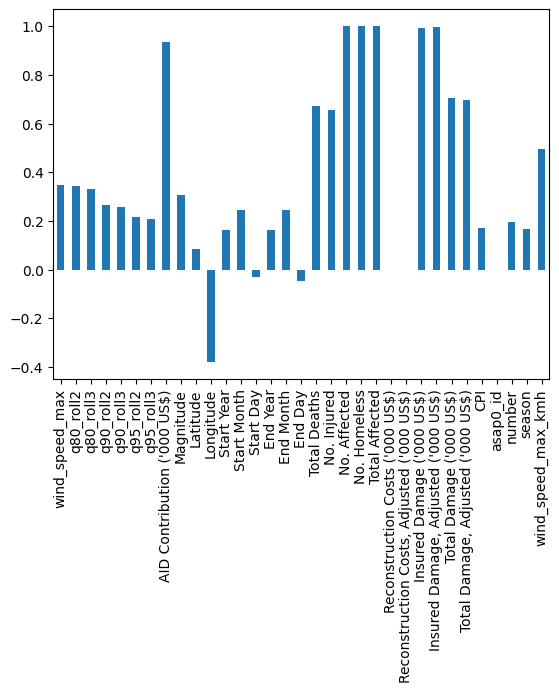

In [47]:
df_stats.corr(numeric_only=True)["Total Affected"].plot.bar()

In [48]:
df_stats_with_impact = df_stats[df_stats["Total Affected"] > 0]

<Axes: >

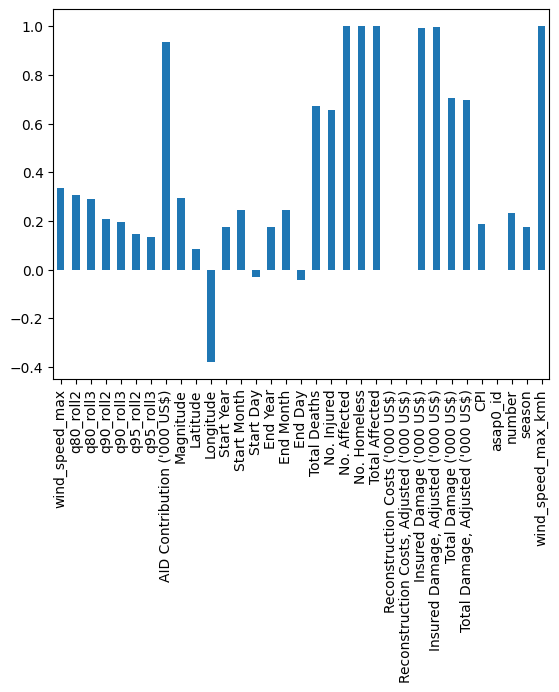

In [49]:
df_stats_with_impact.corr(numeric_only=True)["Total Affected"].plot.bar()

Seems like `q80_roll2` is best for rainfall. We can just check that by running a regression with wind and swapping in the various rainfall columns to see which performs best.

In [50]:
target = "Total Affected"  # your single target column
fixed_col = "wind_speed_max"  # the one you definitely want
other_cols = [
    x for x in df_stats.columns if "roll" in x
]  # the ones you want to test

results = []

for other in other_cols:
    X = df_stats[[fixed_col, other]]
    X = sm.add_constant(X)  # adds intercept term
    y = df_stats[target]

    model = sm.OLS(y, X).fit()
    r2 = model.rsquared

    results.append(
        {
            "other_col": other,
            "r2": r2,
        }
    )

results_df = pd.DataFrame(results).sort_values("r2", ascending=False)
print(results_df)

   other_col        r2
0  q80_roll2  0.216209
1  q80_roll3  0.212031
2  q90_roll2  0.169602
3  q90_roll3  0.168662
4  q95_roll2  0.153397
5  q95_roll3  0.151811


Yeah seems like `q80_roll2` is best but honestly none of these $R^{2}$ values are very good.

## Load IMERG

In [51]:
# get IMERG
query = """
SELECT *
FROM public.imerg
WHERE pcode = 'PH'
"""
with stratus.get_engine(stage="prod").connect() as con:
    df_imerg = pd.read_sql(query, con)

Check to see the most recent dates we have.

In [52]:
df_imerg.sort_values("valid_date").iloc[-10:]

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std
9284,PHL,PH,2025-10-31,0,2.113457,0.660000,0.0,42.840000,9690,20479.395,3.678227
9122,PHL,PH,2025-11-01,0,9.248251,3.252500,0.0,117.454994,9690,89615.555,16.472317
9285,PHL,PH,2025-11-02,0,8.686870,4.425000,0.0,102.710010,9690,84175.766,11.554916
9123,PHL,PH,2025-11-03,0,44.661694,31.015003,0.0,222.105010,9690,432771.780,45.000313
9286,PHL,PH,2025-11-04,0,29.925407,17.329998,0.0,252.264980,9690,289977.220,35.095192
9124,PHL,PH,2025-11-05,0,4.915937,1.360000,0.0,72.454994,9690,47635.430,8.187761
9125,PHL,PH,2025-11-06,0,3.442266,0.992500,0.0,69.105000,9690,33355.555,5.666709
9287,PHL,PH,2025-11-07,0,2.432125,1.415000,0.0,26.154999,9690,23567.295,3.137913
9126,PHL,PH,2025-11-08,0,22.027640,8.485001,0.0,223.105010,9690,213447.810,32.049828
9288,PHL,PH,2025-11-09,0,57.437405,24.580002,0.0,425.490000,9690,556568.440,64.704870


### Get recent IMERG rasters

In [64]:
# grabbing for the most recent dates that seem to be from Fung-Wong
# the max date can be updated once we get more rainfall data
imerg_dates = pd.date_range("2025-11-08", "2025-11-09")

In [ ]:
da_imerg_raw = imerg.open_imerg_raster_dates(imerg_dates)

In [66]:
da_imerg = da_imerg_raw.rio.clip(adm0.geometry)

In [67]:
da_imerg_roll2 = da_imerg.rolling(date=2, min_periods=1).sum()

In [68]:
da_imerg_roll2_q = da_imerg_roll2.quantile(0.8, dim=["x", "y"])

## Get Fung-Wong current values

In [69]:
fungwong_imerg = float(da_imerg_roll2_q.max())

In [70]:
fungwong_imerg

148.20000305175788

In [71]:
# from https://agora.ex.nii.ac.jp/digital-typhoon/summary/wnp/l/202526.html.en
fungwong_wind = 100

## Plot

In [86]:
df_stats_with_impact

,sid,valid_time_min,valid_time_max,wind_speed_max,q80_roll2,q80_roll3,q90_roll2,q90_roll3,q95_roll2,q95_roll3,...,number,season,name,genesis_basin,provisional,storm_id,start_date,end_date,wind_speed_max_kmh,cerf
1,2000299N08139,2000-10-27 18:00:00,2000-10-28 18:00:00,60.0,165.409988,209.722000,224.842987,290.563507,279.513733,349.203461,...,97.0,2000,XANGSANE,WP,False,xangsane_wp_2000,None,None,NaN,False
2,2000305N06136,2000-11-02 06:00:00,2000-11-03 00:00:00,55.0,104.563995,131.760010,203.577957,229.390518,294.647766,338.187714,...,101.0,2000,BEBINCA,WP,False,bebinca_wp_2000,None,None,NaN,False
5,2001181N08141,2001-07-04 06:00:00,2001-07-04 06:00:00,60.0,192.078995,210.889984,291.086487,304.994507,376.147797,397.160248,...,31.0,2001,UTOR,WP,False,utor_wp_2001,None,None,NaN,False
8,2001309N10130,2001-11-06 12:00:00,2001-11-08 18:00:00,55.0,197.825989,236.640976,242.479980,287.031006,288.602234,327.123962,...,91.0,2001,LINGLING,WP,False,lingling_wp_2001,None,None,NaN,False
9,2001338N10130,2001-12-05 00:00:00,2001-12-06 18:00:00,35.0,86.355003,112.931992,124.725510,154.735001,153.920746,184.246994,...,100.0,2001,KAJIKI,WP,False,kajiki_wp_2001,None,None,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2024307N06143,2024-11-07 06:00:00,2024-11-07 18:00:00,100.0,17.968000,22.354998,62.156998,67.197495,163.237503,166.985504,...,89.0,2024,YINXING,WP,False,yinxing_wp_2024,None,None,NaN,False
124,2024312N14145,2024-11-11 00:00:00,2024-11-11 06:00:00,70.0,76.161003,77.755997,130.657501,132.233002,162.623993,165.080505,...,93.0,2024,TORAJI,WP,False,toraji_wp_2024,None,None,NaN,False
125,2024313N10169,2024-11-16 12:00:00,2024-11-17 12:00:00,105.0,82.085991,83.235992,109.657990,110.333504,127.758247,129.356491,...,94.0,2024,MAN-YI,WP,False,man-yi_wp_2024,None,None,NaN,False
135,ineng_2003,2003-07-30 00:00:00,2003-07-31 00:00:00,24.0,43.145000,45.988998,56.284000,60.473499,70.509247,73.251755,...,NaN,2003,INENG,None,None,None,2003-07-30,2003-07-31,45.0,False


In [ ]:
df_stats_with_impact.loc[:, "cerf"] = (
    df_stats_with_impact["storm_id"]
    .str.lower()
    .isin(
        [
            "durian_wp_2006",
            "haiyan_wp_2013",
            "koppu_wp_2015",
            "goni_wp_2020",
            "rai_wp_2021",
            "trami_wp_2024",
            "man-yi_wp_2024",
        ]
    )
)

In [129]:
def plot_stats(
    wind_col="wind_speed_max",
    rain_col="q80_roll2",
    impact_col="Total Affected",
):
    # df_plot = df_stats_with_impact.copy()
    df_plot = df_stats_with_impact[
        df_stats_with_impact["valid_time_min"] >= "2010"
    ]
    # cerf_color = "crimson"
    fig, ax = plt.subplots(figsize=(7, 7), dpi=200)

    ymax = df_plot[rain_col].max() * 1.1
    xmax = df_plot[wind_col].max() * 1.1

    bubble_sizes = df_plot[impact_col].fillna(0)
    bubble_sizes_scaled = bubble_sizes / bubble_sizes.max() * 2000

    ax.scatter(
        df_plot[wind_col],
        df_plot[rain_col],
        s=bubble_sizes_scaled,
        c=df_plot["cerf"].apply(lambda x: cerf_color if x else "k"),
        alpha=0.3,
        edgecolor="none",
        zorder=1,
    )

    for _, row in df_plot.iterrows():
        ax.annotate(
            row["name"].capitalize() + "\n" + str(row["season"]),
            (row[wind_col], row[rain_col]),
            ha="center",
            va="center",
            fontsize=4,
            color=cerf_color if row["cerf"] == True else "k",
            zorder=10 if row["cerf"] else 9,
            alpha=0.8,
        )

    ax.scatter(
        [fungwong_wind],
        [fungwong_imerg],
        marker="x",
        color=CHD_GREEN,
        linewidths=3,
        s=100,
    )
    ax.annotate(
        f"Fung-Wong\nlandfall wind speed\nand rainfall up to {imerg_dates.max().date()}",
        xy=(fungwong_wind, fungwong_imerg),  # point to highlight
        xytext=(
            80,
            260,
        ),  # position of the label
        va="center",
        ha="center",
        color=CHD_GREEN,
        fontweight="normal",
        fontsize=8,
        arrowprops=dict(
            arrowstyle="-",  # simple line, no arrowhead
            color=CHD_GREEN,  # same color as text
            lw=0.5,  # fine line
            alpha=0.8,
        ),
    )
    legend_text = (
        "    Size of bubble proportional to\n"
        "    total number of people affected [EM-DAT]"
        "\n    Red indicates CERF allocation\n\n"
    )
    ax.annotate(
        legend_text,
        (0, 260),
        va="top",
        fontsize=6,
        fontstyle="italic",
        color="grey",
    )

    ylabel = (
        "Two-day rainfall, 80th percentile over whole country (mm) [IMERG]"
        if rain_col == "q80_roll2"
        else rain_col
    )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(
        "Max. wind speed while within 50 km of Philippines (knots) [IBTrACS]"
    )

    ax.set_xlim(left=0, right=xmax)
    ax.set_ylim(bottom=0, top=ymax + 10)

    ax.set_title("Philippines: historical rainfall and wind speed")
    plt.suptitle("Seasons: 2010-2024", y=0.88, fontsize=8, color="gray")

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    return fig, ax

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': 'Philippines: historical rainfall and wind speed'}, xlabel='Max. wind speed while within 50 km of Philippines (knots) [IBTrACS]', ylabel='Two-day rainfall, 80th percentile over whole country (mm) [IMERG]'>)

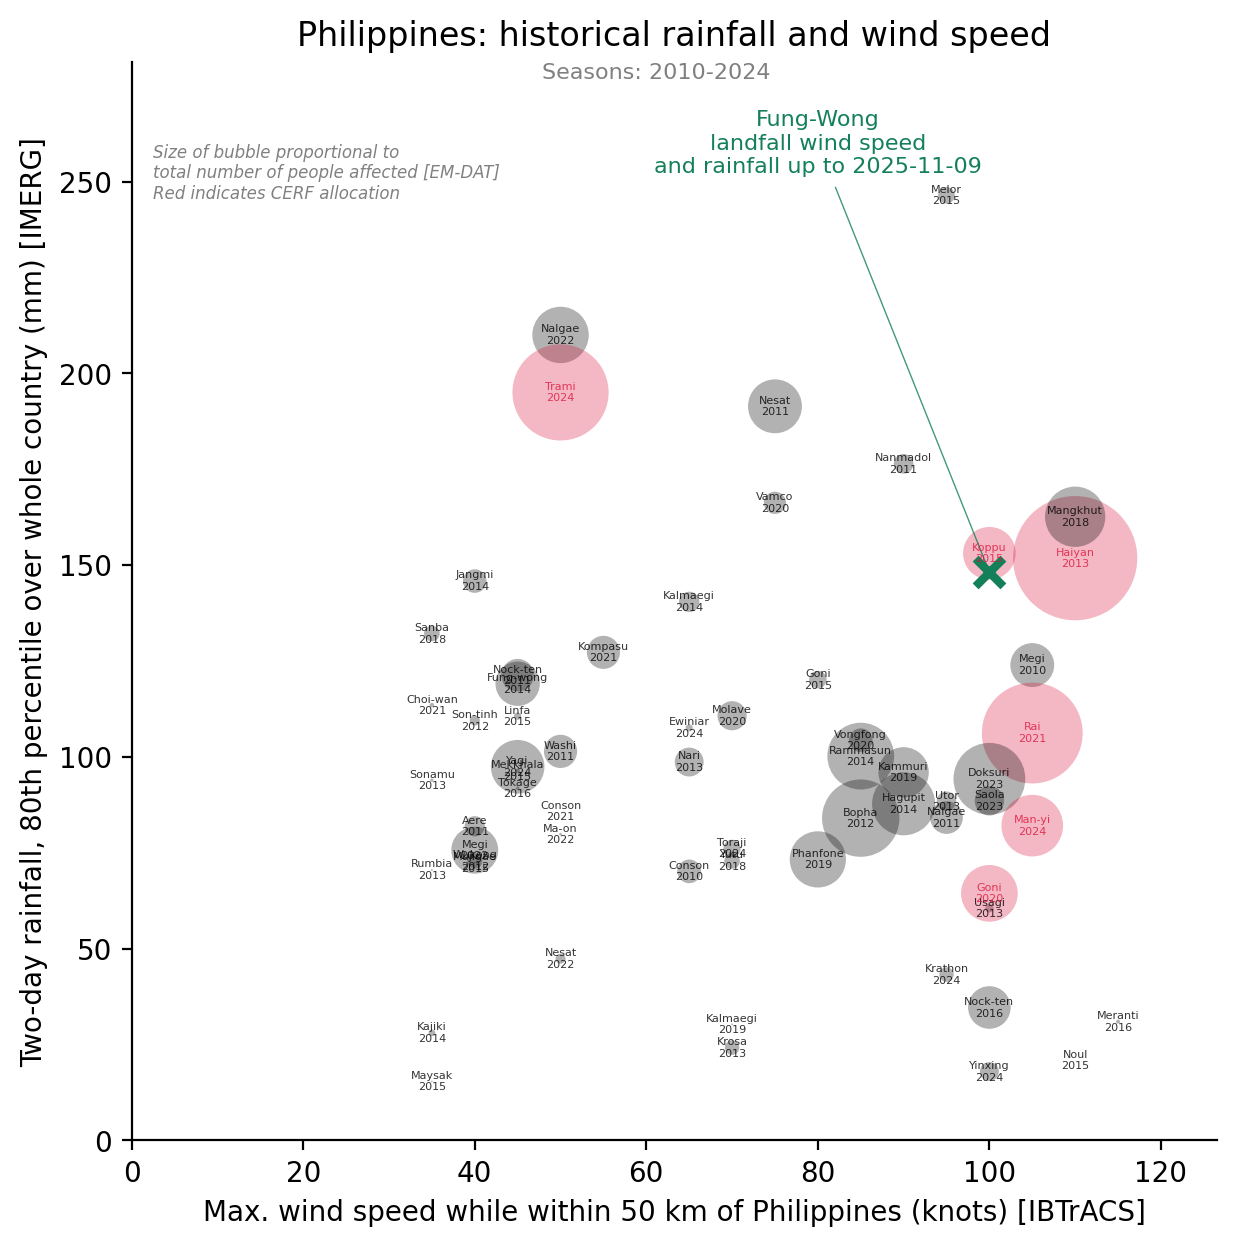

In [130]:
plot_stats()